In [1]:
import retro
import torch
import random
import pyspark
import numpy as np
import IPython.display
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch.nn.functional as F

spark = (pyspark.sql.SparkSession
         .builder
         .master("local[*]")
         .config("spark.executor.memory", "128g")
         .config("spark.driver.memory", "128g")
         .config("spark.memory.offHeap.enabled", True)
         .config("spark.memory.offHeap.size","128g")   
         .appName('lecture')
         .getOrCreate())

sc = spark.sparkContext

In [ ]:
# conf = sc._conf.setAll([
#     ('spark.executor.memory', '64g'),
#     ('spark.driver.memory', '64g'),
#     ('spark.memory.offHeap.enabled', 'true'),
#     ('spark.memory.offHeap.size', '64g'),
#     ('spark.driver.extraJavaOptions', 'Xms20g')])#, ('spark.driver.memory','9.7g')])
# sc._conf.getAll()

mean  
max_  
difference  
frequency  
variance  
reverse tree eg autoenc  

In [139]:
actions_codes = {
    'Left':      [0, 0, 0, 0, 0, 0, 1, 0, 0],
    'Right':     [0, 0, 0, 0, 0, 0, 0, 1, 0],
    'Jump':      [0, 0, 0, 0, 0, 0, 0, 0, 1],
    'None':      [0, 0, 0, 0, 0, 0, 0, 0, 0],
    # 'Crouch':    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    # 'Dash':      [0, 0, 1, 0, 0, 0, 0, 0, 0],
    # 'RightDash': [0, 0, 1, 0, 0, 0, 0, 1, 0],
    'LeftJump':  [0, 0, 0, 0, 0, 0, 1, 0, 1],
    'RightJump': [0, 0, 0, 0, 0, 0, 0, 1, 1]
}

codes_actions = {tuple(code): action for action, code in actions_codes.items()}

# actions = list(actions.values())
actions = list(actions_codes.keys())
actions

['Left', 'Right', 'Jump', 'None', 'LeftJump', 'RightJump']

---
### enchiridion

In [3]:
import uuid

str(uuid.uuid4())

class Environment2:
    def __init__(self):
        self.environment = retro.make(game='SuperMarioBros-Nes')
        # self.environment = retro.make(game='Airstriker-Genesis')
        
        self.blocks_seen = []
        self.blocks_seen_urls = []
        
        self.frames_all = []
        self.actions_all = []

        self.encodings = set()
        self.encodings_frame = set()
        
        asymmetric = torch.linspace(0.5, 1.5, 16*16*3)**3
        asymmetric = asymmetric.numpy()
        
        aa = torch.tensor(asymmetric).reshape(16, 16, 3).unsqueeze(0).permute(0, 3, 1, 2)
        filter_ = torch.tensor(aa, dtype=torch.float)
        self.filter_ = filter_ / 16 / 16 / 3 / 255

        self.frame = self.environment.reset()
        self.frames_all.append(self.frame)


    def step(self, action, commitment_interval):
        for _ in range(commitment_interval):
            self.frame, reward, is_done, information = self.environment.step(action)
        
        # self.blocks_identify(self.frame)
        self.frames_all.append(self.frame)
        self.actions_all.append(action)

        return self.frame, reward, is_done, information

    def close(self):
        self.environment.render(close=True)
        self.environment.close()

    __del__ = close

    
    def blocks_identify_all(self):
        t = torch.tensor(np.stack(self.frames_all)).float()
        images = t.permute(0, 3, 1, 2)
        
        # id_ = str(uuid.uuid4())
        # np.savez_compressed(f'/tmp/{id}.npz', np.stack(self.frames_all).astype('uint8'))

        output = F.conv2d(input=images,
                          weight=self.filter_,
                          stride=16)

        output = output[:, :, 4:-1]
        
        return output[:-1], self.actions_all
    
    def frame_encode(self, frame):
        t = torch.tensor(frame).unsqueeze(0).float()
        images = t.permute(0, 3, 1, 2)

        output = F.conv2d(input=images,
                          weight=self.filter_,
                          stride=16)

        output = output[:, :, 4:-1]
        
        return output

6087 1600


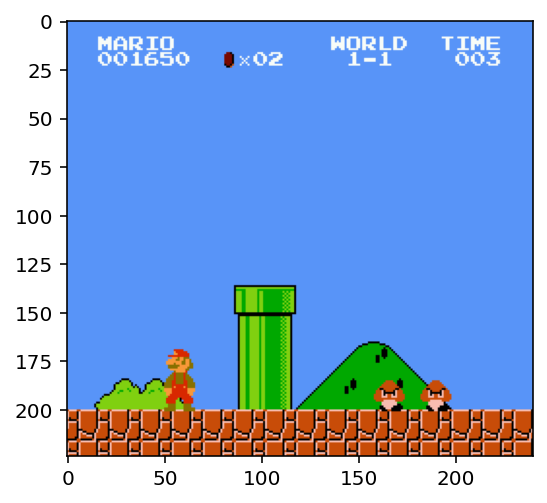

In [4]:
# %%time

import numpy as np
import random

import warnings
warnings.filterwarnings('ignore')

def generate_play(step_count, agent, return_frames=False):
    environment = Environment2()
    
    frame = environment.frame
    for _ in range(step_count or 999999999):
        if agent:
            encoding = environment.frame_encode(frame).flatten().unsqueeze(0)
            action = agent.predict(encoding)[0]
        else:
            action = actions[random.randint(0, len(actions)-1)]
        
        action_code = actions_codes[action]
        frame, reward, is_done, information = environment.step(action_code, 6)

        if information['lives'] == 1:
            break
        
    environment.close()
    
    encodings, actions_all_codes = environment.blocks_identify_all()
    actions_all = [codes_actions[tuple(action_code)] for action_code in actions_all_codes]
    
    result = {
        'EncodingsUniqueCount': len(encodings.unique()),
        'FramesCount': len(encodings),
        'Encodings': encodings,
        'Actions': actions_all,
        'FrameLast': frame
    }
    
    if return_frames:
        return {**result, **{'Frames': environment.frames_all[:-1]}}
    else:
        return result

result = generate_play(1600, None, return_frames=True)
print(result['EncodingsUniqueCount'], result['FramesCount'])
plt.imshow(result['Frames'][-3]);

In [5]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

frames_all = np.array(result['Frames'])
def f(x):
    plt.imshow(frames_all[x])

interact(f, x=widgets.IntSlider(min=0, max=len(frames_all)-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='x', max=1599), Output()), _dom_classes=('widget-interact…

In [ ]:
5

In [6]:
%%time

ls_frames_top = []
for i in range(80000):
    print(i, end='.')
    environments = sc.parallelize(range(256)) .map (lambda x: generate_play(1600, agent=None))
    ls_frames_top.extend(environments.top(4, key=lambda x: x['EncodingsUniqueCount']))
    
    if i % 16 == 0:
        import pickle
        pickle.dump(ls_frames_top, open('ls_frames_top_4_of_256_second', 'wb'))
        !ls -l ls_frames_top_16_of_256

0.-rw-r--r-- 1 root root 6039510 Sep 13 06:06 ls_frames_top_16_of_256
1.2.4.5.6.7.8.9.10.11.12.13.16.-rw-r--r-- 1 root root 6039510 Sep 13 06:06 ls_frames_top_16_of_256
17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.-rw-r--r-- 1 root root 6039510 Sep 13 06:06 ls_frames_top_16_of_256
33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.-rw-r--r-- 1 root root 6039510 Sep 13 06:06 ls_frames_top_16_of_256
49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.-rw-r--r-- 1 root root 6039510 Sep 13 06:06 ls_frames_top_16_of_256
65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.-rw-r--r-- 1 root root 6039510 Sep 13 06:06 ls_frames_top_16_of_256
81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.-rw-r--r-- 1 root root 6039510 Sep 13 06:06 ls_frames_top_16_of_256
97.98.99.100.101.102.103.104.105.106.107.108.109.110.111.112.-rw-r--r-- 1 root root 6039510 Sep 13 06:06 ls_frames_top_16_of_256
113.114.115.116.117.118.119.120.121.122.123.124.125.126.127.128.-rw-r--r-- 1 root root 6039510 Sep 13 06:06 ls_frames_top_

KeyboardInterrupt: 

In [7]:
import pickle
ls_frames_topz = pickle.load(open('ls_frames_top_4_of_256', 'rb'))
len(ls_frames_topz), len(ls_frames_topz)

(2628, 2628)

In [8]:
encodings_all = torch.cat([result['Encodings'].reshape(-1, 9*15) for result in ls_frames_topz])
actions_all = sum([result['Actions'] for result in ls_frames_topz], [])
encodings_all.shape, len(actions_all)

(torch.Size([4198866, 135]), 4198866)

In [45]:
topz = sorted(ls_frames_topz, key=lambda x: -x['EncodingsUniqueCount'])[:20]
topz_actions = [result['Actions'] for result in topz]
topz[0]['EncodingsUniqueCount'] # , topz_actions[0]

7993

7900 1600


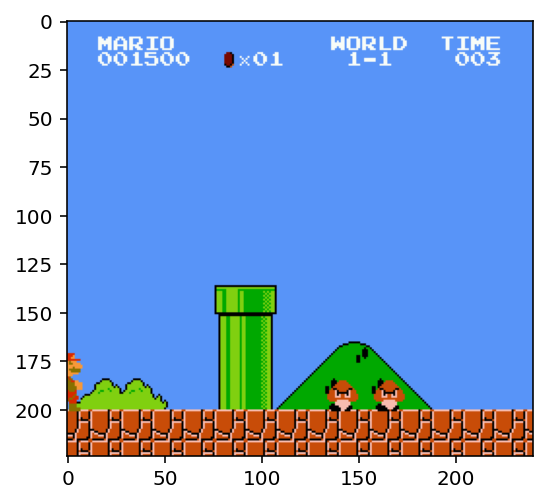

In [52]:
result = generate_play(step_count=None, agent=None, play_actions=topz_actions[3], return_frames=True)
print(result['EncodingsUniqueCount'], result['FramesCount'])
plt.imshow(result['Frames'][-3]);

In [54]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

frames_all = np.array(result['Frames'])
def f(x):
    plt.imshow(frames_all[x])

interact(f, x=widgets.IntSlider(min=0, max=len(frames_all)-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='x', max=1599), Output()), _dom_classes=('widget-interact…

---
### exo

In [72]:
import sklearn.ensemble

classifier = sklearn.ensemble.RandomForestClassifier(n_jobs=-1,
                                                     max_depth=97,
                                                     max_samples=0.3,
                                                     min_samples_leaf=5,
                                                     n_estimators=397)

classifier = sklearn.ensemble.RandomForestClassifier(n_jobs=-1,
                                                     max_depth=77,
                                                     max_samples=0.7,
                                                     min_samples_leaf=5,
                                                     n_estimators=397)

classifier = sklearn.ensemble.RandomForestClassifier(n_jobs=-1,
                                                     max_depth=17,
                                                     max_samples=0.5,
                                                     min_samples_leaf=10,
                                                     n_estimators=97)

classifier.fit(X=encodings_all, y=actions_all)

RandomForestClassifier(max_depth=17, max_samples=0.5, min_samples_leaf=10,
                       n_estimators=97, n_jobs=-1)

In [91]:
filename='trees_ls_top_4_of_256_nestimators_97_maxdepth_17_maxsamples05_minsamplesleaf10.pickle'

In [92]:
#save
import pickle
pickle.dump(classifier, open(filename, 'wb'))
!ls -lh *.pickle

-rw-r--r-- 1 root root 2.1G Sep 13 17:29  trees_ls_top_4_of_256_md97_maxsl03_minsl5.pickle
-rw-r--r-- 1 root root 4.7G Sep 13 17:07  trees_ls_top_4_of_256_md97_msl5.pickle
-rw-r--r-- 1 root root 2.4G Sep 13 17:57  trees_ls_top_4_of_256_nest397_maxd37_maxsl03_minsl5.pickle
-rw-r--r-- 1 root root 8.3G Sep 13 17:37  trees_ls_top_4_of_256_nest397_maxd97_maxsl03_minsl5.pickle
-rw-r--r-- 1 root root 812M Sep 13 18:14  trees_ls_top_4_of_256_nest397_maxd_17_maxsl03_minsl5.pickle
-rw-r--r-- 1 root root 434M Sep 13 18:45  trees_ls_top_4_of_256_nestimators397_maxdepth_17_maxsamples01_minsamplesleaf5.pickle
-rw-r--r-- 1 root root 6.1M Sep 13 18:59  trees_ls_top_4_of_256_nestimators397_maxdepth_7_maxsamples01_minsamplesleaf5.pickle
-rw-r--r-- 1 root root 216M Sep 13 21:59  trees_ls_top_4_of_256_nestimators_397_maxdepth_17_maxsamples04_minsamplesleaf10.pickle
-rw-r--r-- 1 root root 5.2G Sep 13 22:37  trees_ls_top_4_of_256_nestimators_397_maxdepth_77_maxsamples07_minsamplesleaf10.pickle
-rw-r--r-- 1 

In [6]:
#load
import pickle
classifier = pickle.load(open(filename, 'rb'))

### -----------------------------------------------------------------------------

In [95]:
import json

with open('actions.json', 'w') as file:
    file.write(json.dumps(result['Actions']))

6192 1648
CPU times: user 7min 31s, sys: 25.5 s, total: 7min 57s
Wall time: 44.8 s


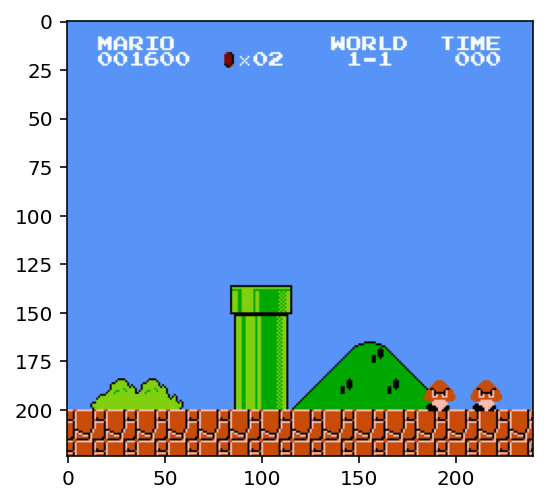

In [96]:
%%time

result = generate_play(step_count=None, agent=classifier, return_frames=True)
print(result['EncodingsUniqueCount'], result['FramesCount'])
plt.imshow(result['Frames'][-3]);

In [98]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

frames_all = np.array(result['Frames'])
def f(x):
    plt.imshow(frames_all[x])

interact(f, x=widgets.IntSlider(min=0, max=len(frames_all)-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='x', max=1647), Output()), _dom_classes=('widget-interact…

In [ ]:
_8_5min11s
_16_13min17s
_6_1min15s
_32_17min

In [132]:
spark = (pyspark.sql.SparkSession
         .builder
         .master("local[*]")
         .config("spark.executor.memory", "128g")
         .config("spark.driver.memory", "128g")
         .config("spark.memory.offHeap.enabled", True)
         .config("spark.memory.offHeap.size","128g")   
         .appName('lecture')
         .getOrCreate())

sc = spark.sparkContext

In [126]:
%%time

environments = sc.parallelize(range(6)) .map (lambda x: generate_play(step_count=None,
                                                                      agent=classifier,
                                                                      return_frames=False))

top_agent = environments.top(2, key=lambda x: x['EncodingsUniqueCount'])

[result['EncodingsUniqueCount'] for result in top_agent]

CPU times: user 108 ms, sys: 97 ms, total: 205 ms
Wall time: 5min 33s


[7689, 7198]

In [141]:
result = generate_play(step_count=None, agent=None, play_actions=actionz, return_frames=True)
print(result['EncodingsUniqueCount'], result['FramesCount'])

frames_all = np.array(result['Frames'])
def f(x):
    plt.imshow(frames_all[x])

interact(f, x=widgets.IntSlider(min=0, max=len(frames_all)-1, step=1, value=0));

7669 1648


interactive(children=(IntSlider(value=0, description='x', max=1647), Output()), _dom_classes=('widget-interact…

In [133]:
%%time

environments = sc.parallelize(range(32)) .map (lambda x: generate_play(step_count=None,
                                                                       agent=classifier,
                                                                       return_frames=False))

# counts = environments .map (lambda x: x['EncodingsUniqueCount'])
ls_top_16 = environments.top(16, lambda x: x['EncodingsUniqueCount'])

CPU times: user 136 ms, sys: 97.3 ms, total: 233 ms
Wall time: 20min 7s


In [134]:
[x['EncodingsUniqueCount'] for x in ls_top_16]

[7669,
 7284,
 7268,
 7241,
 6972,
 6886,
 6851,
 6748,
 6625,
 6614,
 6439,
 6438,
 6250,
 6102,
 5909,
 5602]

In [140]:
actionz = [x['Actions'] for x in ls_top_16 if x['EncodingsUniqueCount'] == 7669][0]

3678 1600


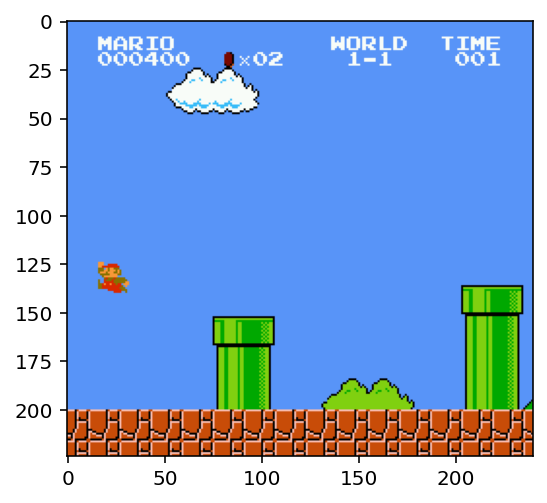

In [112]:
# %%time

import numpy as np
import random

import warnings
warnings.filterwarnings('ignore')

def generate_play(step_count, agent, play_actions=None, return_frames=False):
    environment = Environment2()
    
    frame = environment.frame
    
    for action_1 in play_actions or range(step_count or 999999999):
        if play_actions:
            action = action_1
            
        elif agent:
            encoding = environment.frame_encode(frame).flatten().unsqueeze(0)
            # encoding = scaler.transform(encoding)
            
            # if random.random() < 0.95:
            if random.random() < (1.5 - action_1/1600):
                if random.random() < (1.75 - action_1/1600):
                    action = actions[random.randint(0, len(actions)-1)]
                else:
                    action = agent.predict(encoding)[0]
            else:
                ps = classifier.predict_proba(encoding)[0]
                action = np.random.choice(agent.classes_, p=ps)
            
        else:
            action = actions[random.randint(0, len(actions)-1)]
            
        # print(action)
        
        action_code = actions_codes[action]
        frame, reward, is_done, information = environment.step(action_code, 6)

        if information['lives'] == 1:
            break
        
    environment.close()
    
    encodings, actions_all_codes = environment.blocks_identify_all()
    actions_all = [codes_actions[tuple(action_code)] for action_code in actions_all_codes]
    
    result = {
        'EncodingsUniqueCount': len(encodings.unique()),
        'FramesCount': len(encodings),
        'Encodings': encodings,
        'Actions': actions_all,
        'FrameLast': frame
    }
    
    if return_frames:
        return {**result, **{'Frames': environment.frames_all[:-1]}}
    else:
        return result

result = generate_play(1600, None, return_frames=True)
print(result['EncodingsUniqueCount'], result['FramesCount'])
plt.imshow(result['Frames'][-3]);